In [1]:
import torch
import random
import copy
import os
import cv2

import torch.nn            as nn
import numpy as np
import albumentations                    as A
import torch.nn.functional               as F
import matplotlib.pyplot                 as plt
import pandas as pd
import seaborn as sns
import torch.optim                       as optim

from model.subnet import ImageConvNet, AudioConvNet
from torch.utils.data        import Dataset, DataLoader
from albumentations.pytorch  import ToTensorV2
from sklearn.model_selection import train_test_split
from skimage                 import io
from scipy.io                import wavfile
from scipy                   import signal
from sklearn.decomposition   import PCA

## Functions and classes

In [2]:
#----------------------------------------------------------------------
# overlay the original image and the predicted probability mask
#----------------------------------------------------------------------
# Parameters: numpy image and data predicted
# Return: numpy array whit the overlaped image
#-----------------------------------------------------------------------
def overlay(img, data):
    # convert heatmap data into ndarray
    #print(type(img[0,0,0]), type(data[0,0]))
    data = np.asarray(data) * 255
    data = np.array(data, dtype=np.uint8)

    #img = np.asarray(img) * 255
    #img = np.array(img, dtype=np.uint8)

    # convert heatmap according to cv2.COLORMAP_HOT
    # reference link: https://docs.opencv.org/2.4/modules/contrib/doc/facerec/colormaps.html
    heatmap = cv2.applyColorMap(data, cv2.COLORMAP_HOT)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # resize heatmap to be same with img
    heatmapx16 = cv2.resize(heatmap, None, fx=16, fy=16, interpolation=cv2.INTER_AREA)

    # overlay img and heatmap
    dst = cv2.addWeighted(img, 0.5, heatmapx16, 0.5, 0)

    return dst

In [3]:
#----------------------------------------------------------------------
# Divide the avanible data in the folder named "data" 
# into subset to make training and validation
#----------------------------------------------------------------------
# Parameters: test size to make a partition
# Return: 4 list; videos_train, videos_val, audios_train, audios_val
#-----------------------------------------------------------------------
def generate_train_and_test_sets(test_size = 0.5, path_base = 'data'):

    videos = []
    audios = []
    
    classes = os.listdir(path_base)
    
    for class_ in classes:
        path_class = path_base + '/{}'.format(class_)
        patients = os.listdir(path_class)

        for patient in patients:
            path_patient     = path_class + '/{}'.format(patient)
            exercises        = os.listdir(path_patient)

            for exercise in exercises:
                path_exercise     = path_patient + '/{}'.format(exercise)
                modalities            = os.listdir(path_exercise)
                
                
                path_modality_frames = path_exercise + '/{}'.format('frames')
                path_modality_audio = path_exercise + '/{}'.format('audio')
                data = os.listdir(path_modality_frames)
                videos += [path_modality_frames + '/' + name_string for name_string in data]
                audios += [path_modality_audio + '/' + name_string[:-4] + '.wav' for name_string in data]

    videos_train, videos_val, audios_train, audios_val = train_test_split(videos, audios, test_size=test_size, shuffle=True)
    return videos_train, videos_val, audios_train, audios_val
#videos_train, videos_val, audios_train, audios_val = generate_train_and_test_sets(test_size = 0.5)
#print(videos_train)

In [4]:
#----------------------------------------------------------------------
# Visualize the constructed examples for the self supervised task 
#----------------------------------------------------------------------
# Parameters: 
# dataset: instance of the dataset class
# smaples: number of samples to visualize
#-----------------------------------------------------------------------
def data_visualization(dataset, samples):

    data = copy.deepcopy(dataset)
    data.transform = A.Compose([t for t in data.transform if not isinstance(t, (A.Normalize, ToTensorV2))])

    figure, ax = plt.subplots(nrows=2, ncols=samples, figsize=(12, 6))
    for i in range(samples):
        idx = np.random.randint(0, data.__len__())
        sample      = data[idx]
        image       = sample['image']
        spectrogram = sample['spectrogram']
        label       = sample['label']

        ax[0,i].set_title('Label:{}'.format(label))
        ax[0,i].imshow(image)
        ax[0,i].set_axis_off()

        ax[1,i].imshow(spectrogram[0,:,:])
        ax[1,i].set_axis_off()
    plt.tight_layout()
    plt.show()

In [5]:
#----------------------------------------------------------------
# Avolnet architecture according to "The sound of pixels" paper
#----------------------------------------------------------------
class AVOLNet(nn.Module):
    def __init__(self):
        super(AVOLNet, self).__init__()

        # image subnetwork
        self.icn = ImageConvNet()
        self.im_conv5 = nn.Conv2d(512, 128, 1)
        self.im_conv6 = nn.Conv2d(128, 128, 1)

        # audio subnetwork
        self.acn = AudioConvNet()
        self.aud_pool = nn.AdaptiveMaxPool2d(1)
        self.aud_fc1 = nn.Linear(512, 128)
        self.aud_fc2 = nn.Linear(128, 128)

        # fusion network
        self.fus_conv7 = nn.Conv2d(1, 1, 1)
        self.fus_sig = nn.Sigmoid()
        self.fus_pool = nn.AdaptiveMaxPool2d(1)
        #self.fus_fc = nn.Linear(1, 2)
        # self.fus_fc.weight.data[0] = -0.7
        # self.fus_fc.weight.data[1] = 0.7
        # self.fus_fc.bias.data[0] = 1.2
        # self.fus_fc.bias.data[1] = -1.2

    def forward(self, img, aud):
        # image subnetwork
        img = self.icn(img)
        img = self.im_conv5(img)
        img = self.im_conv6(img)

        # audio subnetwork
        aud = self.acn(aud)
        aud = self.aud_pool(aud)
        aud = aud.squeeze(2).squeeze(2)
        aud = F.relu(self.aud_fc1(aud))
        aud = self.aud_fc2(aud)

        # fusion network
        img = img.view(img.size(0), 128, -1)
        aud = aud.view(aud.size(0), 1, -1)
        scalar_prod = torch.bmm(aud, img).view(aud.size(0), 1, 14, 14)
        loc = self.fus_conv7(scalar_prod)
        loc = self.fus_sig(loc)
        out = self.fus_pool(loc).squeeze()
        #out = self.fus_fc(out)

        return out, loc

In [6]:
#----------------------------------------------------------------------
# Custom Dataset class to generate the dataset for self supervised task 
#----------------------------------------------------------------------
# Parameters: 
# root_dir: root dir to search de data
# names_video: list whit the videos names
# names_audio: list whit the audios names
# transforms: composed funtions to make data augmentation
#-----------------------------------------------------------------------
class AudioVisualDataset(Dataset):
    # Start the configuration of the class
    # and adjust the data to do the self supervised task "Audio visual correspondence" 
    def __init__(self, names_videos, names_audios, transform=None):
        
        self.videos = names_videos
        self.audios = names_audios
        self.__shuffle__()
        self.transform = transform

    # For every pair of audio and video, this function create the positive and negative
    # example for the visual correspondence task
    def __shuffle__(self):

        new_videos = []
        new_audios = []
        labels     = []

        for index, video in enumerate(self.videos):
            #positive case
            new_videos.append(video)
            new_audios.append(self.audios[index])
            labels.append(1)
            #negative case 
            rand_index = random.randint(0, len(self.audios)-1)

            while rand_index == index:
                rand_index = random.randint(0, len(self.audios)-1)
            
            new_videos.append(video)
            new_audios.append(self.audios[rand_index])
            labels.append(0)

        self.videos = new_videos
        self.audios = new_audios
        self.labels = labels
    
    # Return the total of elements in the dataset
    def __len__(self):
        return len(self.videos)

    # This funtion is called in every epoch to get one image to construct 
    # the mini batch data 
    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        frames = os.listdir(self.videos[idx])
        frame_name = frames[len(frames)//2]
        label_class = self.videos[idx].split('/')[-1][0]
        frame = io.imread(self.videos[idx] + '/' + frame_name)   
    
        audio_name = self.audios[idx]
        rate, sample = wavfile.read(audio_name)
        
        if sample.shape[1] == 2:
            sample = np.mean(sample,axis=1)

        middle_sample = len(sample)//2
        cur_sample = sample[middle_sample-24000:middle_sample+24000]
        fr, time, spectrogram = signal.spectrogram(cur_sample,fs=48000.,nperseg=480,noverlap=240,nfft=512)

        spectrogram = np.expand_dims(10 * np.log10(spectrogram + 1e-7), 0)
        
        if self.transform:
            frame = self.transform(image = frame)["image"]
        final_data = {'image':frame, 'spectrogram': spectrogram, 'label':self.labels[idx], 'label_class':label_class}

        return final_data

In [7]:
#----------------------------------------------------------------------
# Custom train loop 
#----------------------------------------------------------------------
# Parameters: 
# use_cuda: boolean, to use the gpu
# lr: float, learning rate
# epuch: int, number of epuchs in training
# batch_size: int, size of mini batch used in every epuch
#-----------------------------------------------------------------------
def train(train_data, val_data, use_cuda=True, lr=1e-5, epoch=10, batch_size=5, weights_path=None):

    # gpu settings
    if use_cuda and torch.cuda.is_available():
        device = torch.device("cuda")
        print("Using GPU for training:", torch.cuda.get_device_name())
    else:
        if use_cuda:
            print("Failed to find GPU, using CPU instead.")
        device = torch.device("cpu")
    print("Current device:", device)

    results = {'train_loss':[],
               'train_acc' :[],
               'val_loss':[],
               'val_acc' :[],}

    # Instance model
    model = AVOLNet()
    if weights_path != None:
        model.load_state_dict(torch.load(weights_path))
        model.fus_conv7 = nn.Conv2d(1, 1, 1)
        model.fus_sig = nn.Sigmoid()
        model.fus_pool = nn.AdaptiveMaxPool2d(1)
    model.to(device)

    # Define loss metric
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # genereate dataset
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
    val_dataloader   = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=0)

    #Start training 
    for e in range(epoch):
        train_loss = 0
        train_correct = 0
        train_total = 0
        model.train()
    
        for i, data in enumerate(train_dataloader, start=1):
            # Train stage
            img, aud, label = data['image'].to(device), data['spectrogram'].to(device), data['label'].to(device)
            #print(aud.shape)
            out, _ = model(img.float(), aud.float())
            label = label.float()
            loss = criterion(torch.round(out), label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Training metrics
            with torch.no_grad():
                prediction = torch.round(out)
                train_loss += loss.item()
                train_correct += (label == prediction).sum().item()
                train_total += label.size(0)

                train_loss /= 100
                train_acc = train_correct / train_total

        # Validation metrics
        val_loss = 0
        val_correct = 0
        val_total = 0
        model.eval()

        for j, data in enumerate(val_dataloader):
            img, aud, label = data['image'].to(device), data['spectrogram'].to(device), data['label'].to(device)
            with torch.no_grad():
                out, _ = model(img.float(), aud.float())
                label = label.float()
                loss = criterion(torch.round(out), label)
                prediction = torch.round(out)
                val_loss += loss.item()
                val_correct += (label == prediction).sum().item()
                val_total += label.size(0)

                val_loss /= 100
                val_acc = val_correct / val_total

        print("Epoch: {}, train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(e+1, train_loss, train_acc, val_loss, val_acc))

        results['train_loss'].append(train_loss)
        results['train_acc'].append(train_acc)
        results['val_loss'].append(val_loss)
        results['val_acc'].append(val_acc)
        
    return results, model

## Embedding space without transfer learning

In [16]:
#----------------------------------------------------------------
# Select the GPU to improve the evaluation stage
#----------------------------------------------------------------
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU for training:", torch.cuda.get_device_name())
else:
    device = torch.device("cpu")
    print("Failed to find GPU, using CPU instead.")
print("Current device:", device)

Using GPU for training: NVIDIA GeForce GTX 1050
Current device: cuda


In [10]:
#----------------------------------------------------------------
# Instance the model and load the weights for Musig dataset 
#----------------------------------------------------------------
weights_path = 'save/AVOL-Net_inst.pt'
model = AVOLNet()
model.load_state_dict(torch.load(weights_path))
model.to(device)
model.eval()

AVOLNet(
  (icn): ImageConvNet(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3_

In [11]:
#----------------------------------------------------------------
# Transformations for validation set
#----------------------------------------------------------------
transforms = A.Compose([A.SmallestMaxSize(max_size=224),
                        A.CenterCrop(height=224, width=224),
                        #A.Blur(p=0.5),
                        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                        ToTensorV2(),
                       ])

In [12]:
videos_train, videos_val, audios_train, audios_val = generate_train_and_test_sets(test_size = 0.5)

In [13]:
videos = videos_train + videos_val
audios = audios_train + audios_val

#print("total de videos({}) y audios({})".format(len(videos),len(audios)))

In [14]:
data = AudioVisualDataset(names_videos=videos,
                          names_audios=audios,
                          transform = transforms)
print('Samples: {}'.format(data.__len__()))

Samples: 592


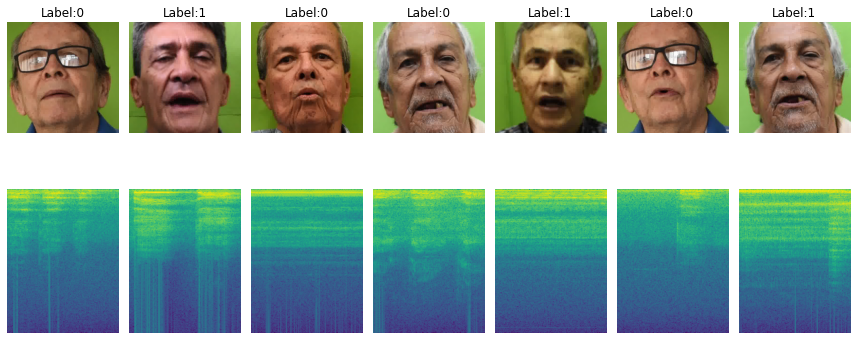

In [15]:
data_visualization(dataset = data, samples=7)

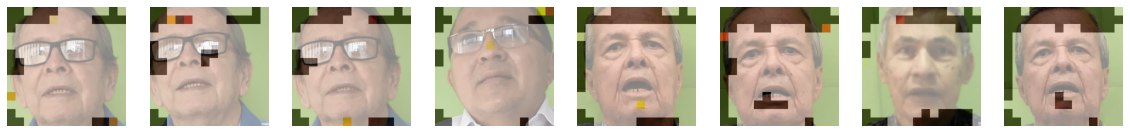

In [16]:
overlaped_results = []
localizations     = []
labels_class       = []
vowels            = []

for idx in range(592):
    sample = data[idx]
    
    image       = sample['image'].to(device)
    image       = image.unsqueeze(0)
    aud         = torch.from_numpy(sample['spectrogram']).to(device)
    aud         = aud.unsqueeze(0)
    label       = sample['label']
    label_class = sample['label_class']

    if label == 1:

        out, localization = model(image.float(), aud.float())
        localization_np   = localization.detach().cpu().numpy()[0,0,:,:]
        image_np          = image.permute(0,2,3,1).detach().cpu().numpy()[0,:,:,:]
        overlaped         = overlay(image_np, localization_np)

        overlaped_results.append(overlaped)
        localizations.append(localization_np)
        labels_class.append(label_class)
        #print(image_np.shape, localization_np.shape, overlaped.shape)

samples = 8
plt.figure(figsize=(20,20))
for idx in range(samples):
    plt.subplot(1,samples,idx+1)
    idx_sample = np.random.randint(0, len(overlaped_results)-1)
    plt.imshow(overlaped_results[idx_sample])
    plt.axis('off')

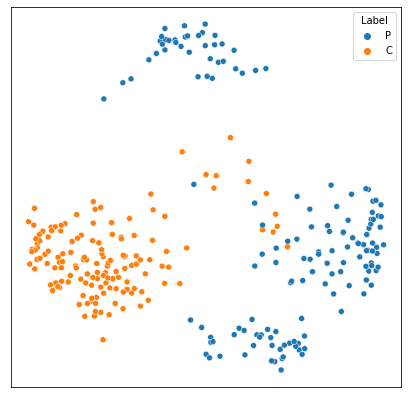

In [18]:
X = []
for localization in localizations:

    X.append(localization.ravel())

pca = PCA(n_components=2)
X_r2 = pca.fit_transform(X)


data_df = pd.DataFrame({'X':X_r2[:,0], 'Y':X_r2[:,1],'Label':labels_class})

plt.figure(figsize=(7,7))
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
sns.scatterplot(data=data_df, x="X", y="Y", hue='Label')
plt.show()

## Embedding space with transfer learning

In [8]:
#----------------------------------------------------------------
# Transformations for training set
#----------------------------------------------------------------
train_transform = A.Compose([
        A.SmallestMaxSize(max_size=224),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.CenterCrop(height=224, width=224),
        #A.Blur(p=0.5),
        #A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])
#----------------------------------------------------------------
# Transformations for validation set
#----------------------------------------------------------------
val_transform = A.Compose([
        A.SmallestMaxSize(max_size=224),
        A.CenterCrop(height=224, width=224),
        #A.Blur(p=0.5),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ])

In [9]:
videos_train, videos_val, audios_train, audios_val = generate_train_and_test_sets(test_size = 0.5)

In [10]:
train_data = AudioVisualDataset(names_videos=videos_train,
                                names_audios=audios_train,
                                transform = train_transform
                                )
val_data   = AudioVisualDataset(names_videos=videos_val,
                                names_audios=audios_val,
                                transform = val_transform
                                )

print('Training samples: {}'.format(train_data.__len__()))
print('validation samples: {}'.format(val_data.__len__()))

Training samples: 296
validation samples: 296


In [11]:
results, model = train(train_data, val_data, batch_size=30, lr=0.001, epoch=100, weights_path='save/AVOL-Net_inst.pt')

Using GPU for training: NVIDIA GeForce GTX 1050
Current device: cuda
Epoch: 1, train_loss: 0.0630, train_acc: 0.5000, val_loss: 0.0814, val_acc: 0.5000
Epoch: 2, train_loss: 0.0378, train_acc: 0.5000, val_loss: 0.0548, val_acc: 0.5000
Epoch: 3, train_loss: 0.0287, train_acc: 0.5000, val_loss: 0.0232, val_acc: 0.5000
Epoch: 4, train_loss: 0.0302, train_acc: 0.5000, val_loss: 0.0196, val_acc: 0.5000
Epoch: 5, train_loss: 0.0185, train_acc: 0.5000, val_loss: 0.0191, val_acc: 0.5000
Epoch: 6, train_loss: 0.0166, train_acc: 0.5000, val_loss: 0.0143, val_acc: 0.5000
Epoch: 7, train_loss: 0.0133, train_acc: 0.5000, val_loss: 0.0163, val_acc: 0.5000
Epoch: 8, train_loss: 0.0104, train_acc: 0.5000, val_loss: 0.0077, val_acc: 0.5000
Epoch: 9, train_loss: 0.0080, train_acc: 0.5034, val_loss: 0.0082, val_acc: 0.4966
Epoch: 10, train_loss: 0.0078, train_acc: 0.5000, val_loss: 0.0078, val_acc: 0.4966
Epoch: 11, train_loss: 0.0083, train_acc: 0.5000, val_loss: 0.0074, val_acc: 0.5034
Epoch: 12, train

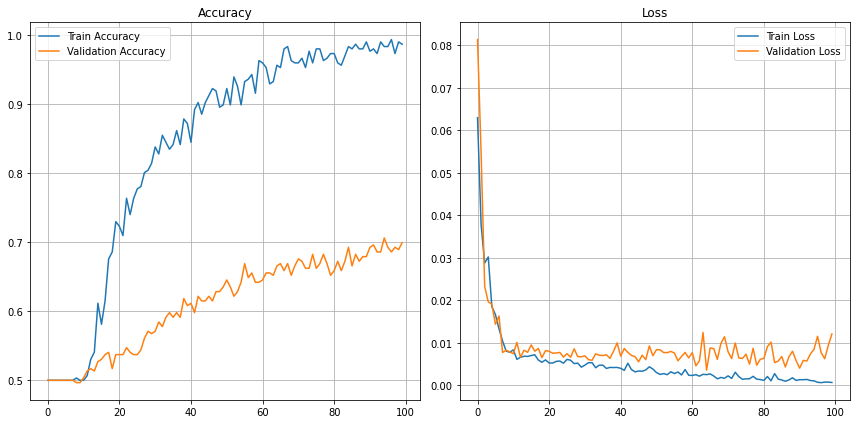

In [14]:
figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

ax[0].set_title('Accuracy')
ax[0].plot(results['train_acc'], label='Train Accuracy')
ax[0].plot(results['val_acc'], label='Validation Accuracy')
ax[0].grid()
ax[0].legend()

ax[1].set_title('Loss')
ax[1].plot(results['train_loss'], label='Train Loss')
ax[1].plot(results['val_loss'], label='Validation Loss')
ax[1].grid()
ax[1].legend()

plt.tight_layout()
plt.show()

In [17]:
dataloader   = DataLoader(val_data, batch_size=1, shuffle=True, num_workers=0)
predictions  = []
images       = []
heat_maps    = []
labels_class = []
vowels       = []
for sample in dataloader:

    image       = sample['image'].to(device)
    aud         = sample['spectrogram'].to(device)
    label       = sample['label'].to(device)
    label_class = sample['label_class'][0]

    if label == 1:

        out, localization = model(image.float(), aud.float())
        localization_np   = localization.detach().cpu().numpy()[0,0,:,:]
        image_np          = image.permute(0,2,3,1).detach().cpu().numpy()[0,:,:,:]

        predictions.append(localization_np)
        images.append(image_np)
        heat_maps.append(overlay(image_np, localization_np))
        labels_class.append(label_class)

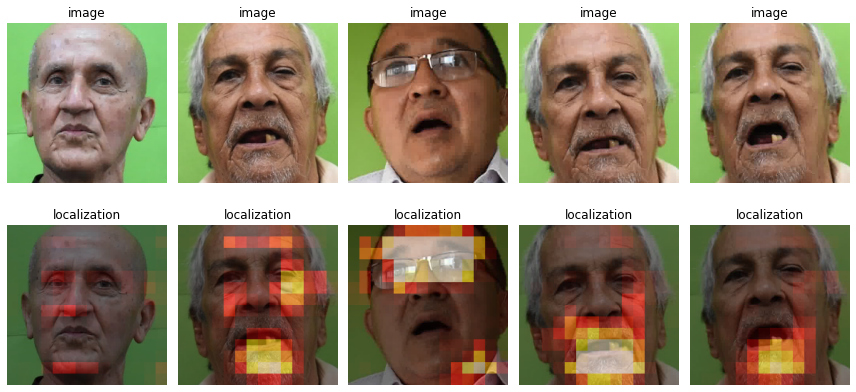

In [18]:
figure, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))

for index, heat_map in enumerate(heat_maps):
    
    if index <5:
        ax[0,index].set_title('image')
        ax[0,index].imshow(images[index])
        ax[0,index].set_axis_off()

        ax[1,index].set_title('localization')
        ax[1,index].imshow(heat_map)
        ax[1,index].set_axis_off()

plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='X', ylabel='Y'>

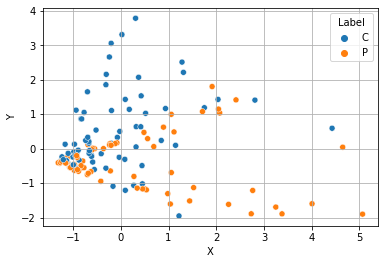

In [19]:
X = []
for localization in predictions:

    X.append(localization.ravel())

pca = PCA(n_components=2)
X_r2 = pca.fit_transform(X)

data_df = pd.DataFrame({'X':X_r2[:,0], 'Y':X_r2[:,1],'Label':labels_class})

plt.grid()
sns.scatterplot(data=data_df, x="X", y="Y", hue='Label')